In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/datasets

/content/gdrive/My Drive/datasets


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math


## **RATING PRODUCT AND SORTING REVIEWS IN AMAZON**

Days between 2012-06-09 and 2014-07-23 of [Amazon Product Review Data](https://snap.stanford.edu/data/amazon/productGraph/) used for this project. 



**Understanding Data**

**reviewerID:** User ID.

**asin:** Product ID.

**reviewerName:** Username

**helpful:** helpfulness of the review - [2,4]

**reviewText:** review of the users

**overall:** Product rating

**summary:** Review summary

**unixReviewTime:** Review time (Unix time)

**reviewTime:** Review time (raw)




### **GOALS:**

1.   to calculate product ratings more accurately
2.   to sort product reviews with a better strategy, Wilson Lower bound Score 


In [ ]:
df_ = pd.read_csv("df_sub.csv")

In [ ]:
df = df_.copy()

In [ ]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,"07 23, 2014"
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,"10 25, 2013"
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,"12 23, 2012"
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,"11 21, 2013"
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,"07 13, 2013"


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,4915.0,4.587589e+00,9.968451e-01,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
unixReviewTime,4915.0,1.379465e+09,1.581857e+07,1.339200e+09,1.365898e+09,1.381277e+09,1.392163e+09,1.406074e+09


In [ ]:
df["overall"].mean()  # average score of the product

4.587589013224822

**Calculate Weighted Average Point of Product according to the Date of Review**

In [ ]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'], dayfirst=False)
df['reviewTime'].min()

Timestamp('2012-06-09 00:00:00')

In [ ]:
df['reviewTime'].max()

Timestamp('2014-07-23 00:00:00')

In [ ]:
current_date = pd.to_datetime('2021-02-19 0:0:0')
df["day_diff"] = (current_date - df['reviewTime']).dt.days
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,2403
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,2674
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,2980
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,2647
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,2778


In [ ]:

a = df["day_diff"].quantile(0.25)
b = df["day_diff"].quantile(0.50)
c = df["day_diff"].quantile(0.75)

In [ ]:
f"a = {a}, b= {b}, c={c}"

'a = 2564.0, b= 2690.0, c=2868.0'

Average Point Before : **4.587**

New Average Point of Product is **4.63**

In [ ]:

df.loc[df["day_diff"] <= a, "overall"].mean() * 40 / 100 + \
df.loc[(df["day_diff"] > a) & (df["day_diff"] <= b), "overall"].mean() * 30 / 100 + \
df.loc[(df["day_diff"] > b) & (df["day_diff"] <= c), "overall"].mean() * 20 / 100 + \
df.loc[(df["day_diff"] > c), "overall"].mean() * 10 / 100


4.631733391912294

Let's choose top 20 comments of the product by using 'helpful' feature. **[positive vote, total vote]**

In [ ]:
df["helpful"].value_counts()

[0, 0]          4360
[1, 1]           266
[0, 1]           114
[1, 2]            46
[2, 2]            28
[0, 2]            22
[1, 3]             9
[3, 3]             7
[0, 3]             6
[4, 4]             5
[3, 4]             5
[5, 5]             5
[3, 5]             4
[6, 8]             3
[6, 7]             3
[4, 5]             3
[2, 3]             3
[7, 7]             2
[51, 65]           1
[1, 7]             1
[5, 6]             1
[45, 49]           1
[14, 16]           1
[1, 5]             1
[60, 68]           1
[422, 495]         1
[1568, 1694]       1
[5, 7]             1
[53, 236]          1
[4, 6]             1
[2, 4]             1
[22, 25]           1
[6, 6]             1
[112, 139]         1
[82, 109]          1
[15, 21]           1
[4, 13]            1
[38, 48]           1
[1428, 1505]       1
[8, 10]            1
[1952, 2020]       1
[8, 118]           1
Name: helpful, dtype: int64

In [ ]:
df["helpful"] = df["helpful"].str[1:-1].str.split(',').to_list()

In [ ]:
df["helpful_yes"] = [int(i[0]) for i in df['helpful']]
df["helpful_no"] = [(int(i[1]) - int(i[0])) for i in df['helpful']]
df["total_vote"] = [int(i[1]) for i in df['helpful']]

In [ ]:
df["score_pos_neg_diff"] = df["helpful_yes"] - df["helpful_no"]

In [ ]:
def score_average_rating(pos, neg):
    if pos + neg == 0:
        return 0
    return pos / (pos + neg)

In [ ]:
df["score_average_rating"] = df.apply(lambda x: score_average_rating(x['helpful_yes'], x['total_vote']), axis=1)

In [ ]:
df[['overall', 'score_average_rating']].sort_values(by='score_average_rating', ascending=False).head(10)

,overall,score_average_rating
4277,5.0,0.5
2881,5.0,0.5
1073,5.0,0.5
445,4.0,0.5
3923,5.0,0.5
435,5.0,0.5
2901,5.0,0.5
2204,2.0,0.5
2206,5.0,0.5
3408,5.0,0.5


**Create new scores with Wilson Lower Bound rule**

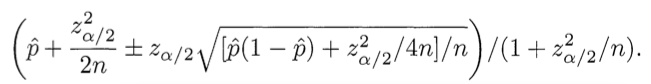

In [ ]:
def wilson_lower_bound(pos, neg, confidence=0.95):
    """
    calculates Wilson Lower Bound Score 
    Score = Lower bound of Wilson score confidence interval for a Bernoulli parameter
    - scores between 1-3 are "down", 4-5 are "up"
    Parameters
    ----------
    pos: int
        positive comment number
    neg: int
        negative comment number
    confidence: float

    Returns
    -------
    wilson score: float

    """
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

In [ ]:
df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x['helpful_yes'], x['helpful_no']), axis=1)

In [ ]:
df.sort_values(by="wilson_lower_bound", ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.0,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-05-01,2851,1952,68,2020,1884,0.491440,0.957544
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.0,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,3068,1428,77,1505,1351,0.486874,0.936519
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.0,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-08-05,2755,1568,126,1694,1442,0.480687,0.912139
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.0,"Warning, read this!",1346544000,2012-09-02,3092,422,73,495,349,0.460196,0.818577
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.0,Super high capacity!!! Excellent price (on Am...,1394150400,2014-03-07,2541,45,4,49,41,0.478723,0.808109
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.0,I own it,1393545600,2014-02-28,2548,60,8,68,52,0.468750,0.784651
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.0,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,3042,112,27,139,85,0.446215,0.732136
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.0,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,2914,22,3,25,19,0.468085,0.700442
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.0,Awesome Card!,1339200000,2012-06-09,3177,51,14,65,37,0.439655,0.670334
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.0,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,3072,82,27,109,55,0.429319,0.663595


In [ ]:
df[['helpful', 'score_pos_neg_diff', 'overall', 'score_average_rating', 'wilson_lower_bound']].sort_values(
    by="wilson_lower_bound", ascending=False).head(20)

,helpful,score_pos_neg_diff,overall,score_average_rating,wilson_lower_bound
2031,"[1952, 2020]",1884,5.0,0.491440,0.957544
3449,"[1428, 1505]",1351,5.0,0.486874,0.936519
4212,"[1568, 1694]",1442,1.0,0.480687,0.912139
317,"[422, 495]",349,1.0,0.460196,0.818577
4672,"[45, 49]",41,5.0,0.478723,0.808109
1835,"[60, 68]",52,5.0,0.468750,0.784651
3981,"[112, 139]",85,5.0,0.446215,0.732136
3807,"[22, 25]",19,3.0,0.468085,0.700442
4306,"[51, 65]",37,5.0,0.439655,0.670334
4596,"[82, 109]",55,1.0,0.429319,0.663595
